In [ ]:
import pandas as pd
from google.colab import files

# Upload the Excel file
uploaded = files.upload()

# Load the dataset
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_')
df.dropna(subset=['Customer_ID'], inplace=True)
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


Saving online_retail_II.xlsx to online_retail_II.xlsx


In [ ]:
# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['Price']

# Aggregate features per customer
customer_features = df.groupby('Customer_ID').agg({
    'InvoiceDate': ['min', 'max', 'count'],
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'Country': 'first'
})

# Flatten MultiIndex columns
customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]
customer_features.reset_index(inplace=True)

# Create derived features
customer_features['Customer_Age_Days'] = (df['InvoiceDate'].max() - customer_features['InvoiceDate_min']).dt.days
customer_features['Frequency'] = customer_features['Invoice_nunique']
customer_features['Avg_Purchase_Value'] = customer_features['TotalPrice_sum'] / customer_features['Frequency']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare features and target
X = customer_features[['Customer_Age_Days', 'Frequency', 'Quantity_sum', 'Avg_Purchase_Value']]
y = customer_features['TotalPrice_sum']  # Using total historical spend as proxy CLV

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)


# Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


RMSE: 3474.32


Enter Customer ID to predict CLV: 17850

Customer Details:
Country: United Kingdom
Total Purchases: 155
Total Quantity Purchased: 21052
Avg Purchase Value: £330.38
Customer Since (days): 369

Predicted Customer Lifetime Value: £65361.48


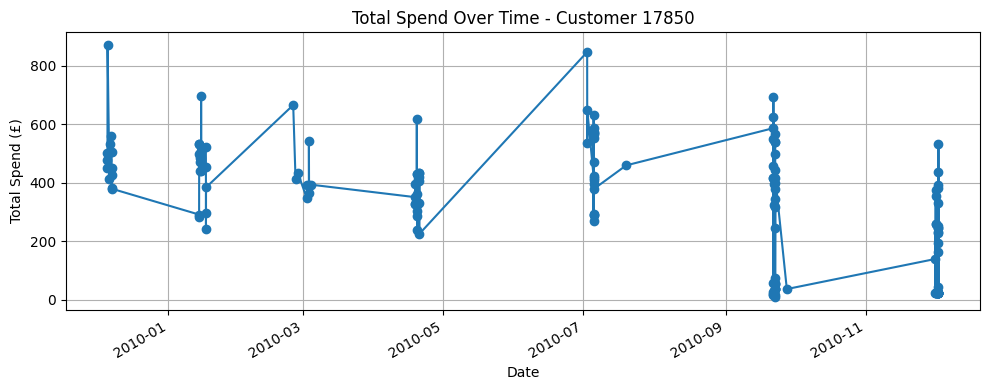

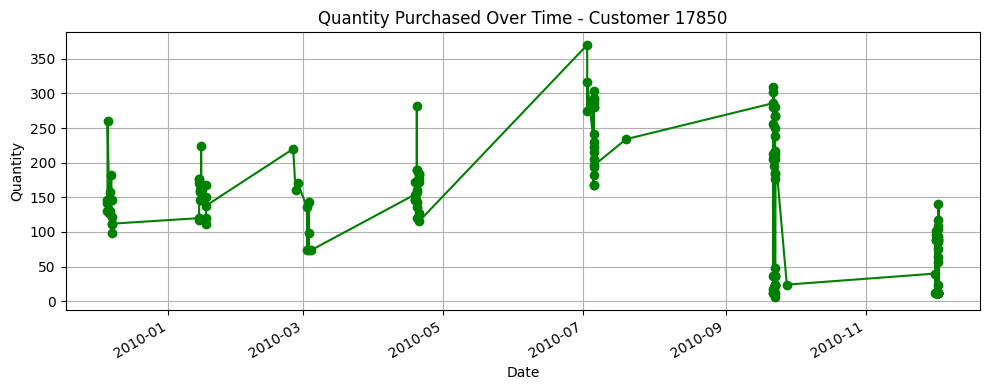

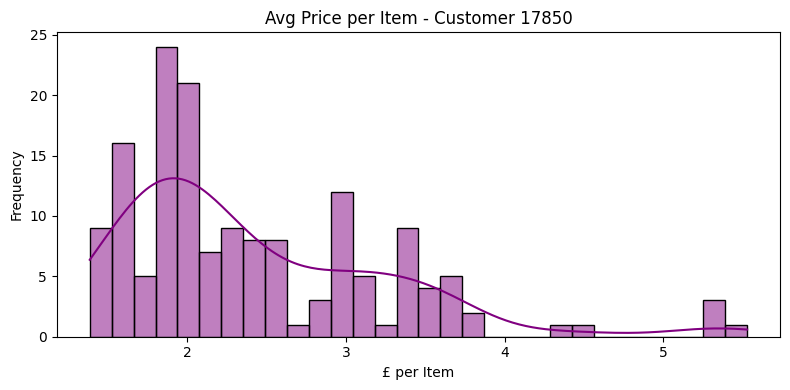

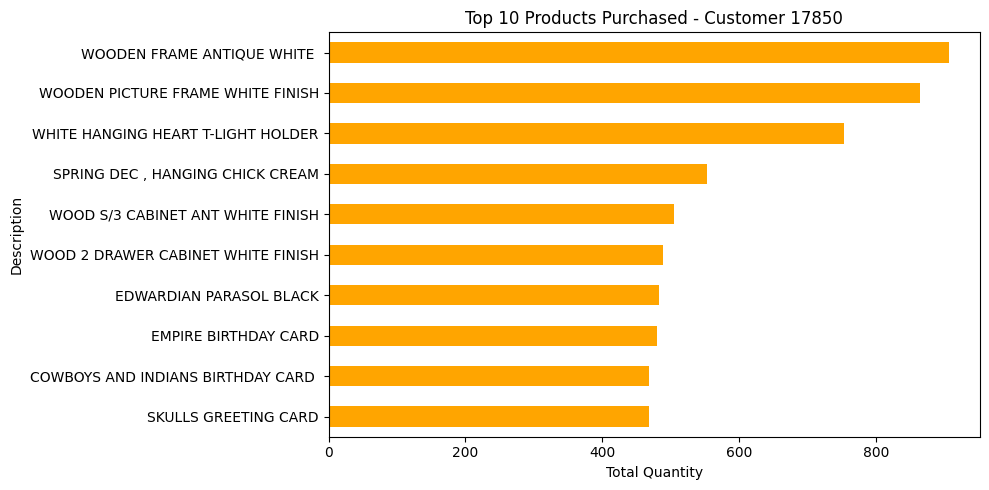

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ask user to enter Customer ID
customer_id = input("Enter Customer ID to predict CLV: ")

try:
    customer_id = int(customer_id)
    row = customer_features[customer_features['Customer_ID'] == customer_id]

    if not row.empty:
        # Show customer details
        print("\nCustomer Details:")
        print(f"Country: {row['Country_first'].values[0]}")
        print(f"Total Purchases: {row['Frequency'].values[0]}")
        print(f"Total Quantity Purchased: {row['Quantity_sum'].values[0]}")
        print(f"Avg Purchase Value: £{row['Avg_Purchase_Value'].values[0]:.2f}")
        print(f"Customer Since (days): {row['Customer_Age_Days'].values[0]}")

        # Prepare input for prediction
        X_input = row[['Customer_Age_Days', 'Frequency', 'Quantity_sum', 'Avg_Purchase_Value']]
        clv_pred = model.predict(X_input)[0]
        print(f"\nPredicted Customer Lifetime Value: £{clv_pred:.2f}")

        # ----------------------------
        #       Graph Section
        # ----------------------------
        cust_df = df[df['Customer_ID'] == customer_id].copy()
        cust_df['InvoiceDate'] = pd.to_datetime(cust_df['InvoiceDate'])
        cust_df['TotalPrice'] = cust_df['Quantity'] * cust_df['Price']

        # 1. Total Spend Over Time
        plt.figure(figsize=(10, 4))
        cust_df.groupby('InvoiceDate')['TotalPrice'].sum().plot(marker='o')
        plt.title(f'Total Spend Over Time - Customer {customer_id}')
        plt.ylabel('Total Spend (£)')
        plt.xlabel('Date')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 2. Quantity Purchased Over Time
        plt.figure(figsize=(10, 4))
        cust_df.groupby('InvoiceDate')['Quantity'].sum().plot(marker='o', color='green')
        plt.title(f'Quantity Purchased Over Time - Customer {customer_id}')
        plt.ylabel('Quantity')
        plt.xlabel('Date')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 3. Avg Basket Size per Invoice
        basket = cust_df.groupby('Invoice').agg({
            'Quantity': 'sum',
            'TotalPrice': 'sum'
        })
        basket['AvgPricePerItem'] = basket['TotalPrice'] / basket['Quantity']

        plt.figure(figsize=(8, 4))
        sns.histplot(basket['AvgPricePerItem'], kde=True, bins=30, color='purple')
        plt.title(f'Avg Price per Item - Customer {customer_id}')
        plt.xlabel('£ per Item')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # 4. Top Products Purchased
        top_products = cust_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
        plt.figure(figsize=(10, 5))
        top_products.plot(kind='barh', color='orange')
        plt.title(f'Top 10 Products Purchased - Customer {customer_id}')
        plt.xlabel('Total Quantity')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    else:
        print("Customer ID not found.")
except ValueError:
    print("Invalid Customer ID format.")
